# Build Topology for Jellyfish

First, let us set host / switch and links:

In [1]:
host = 50
link = 8

Import necessay lib:

In [2]:
import os
import sys
import networkx as nx
import random
import matplotlib.pyplot as plt
import pickle
from itertools import islice

... and draw the topology!

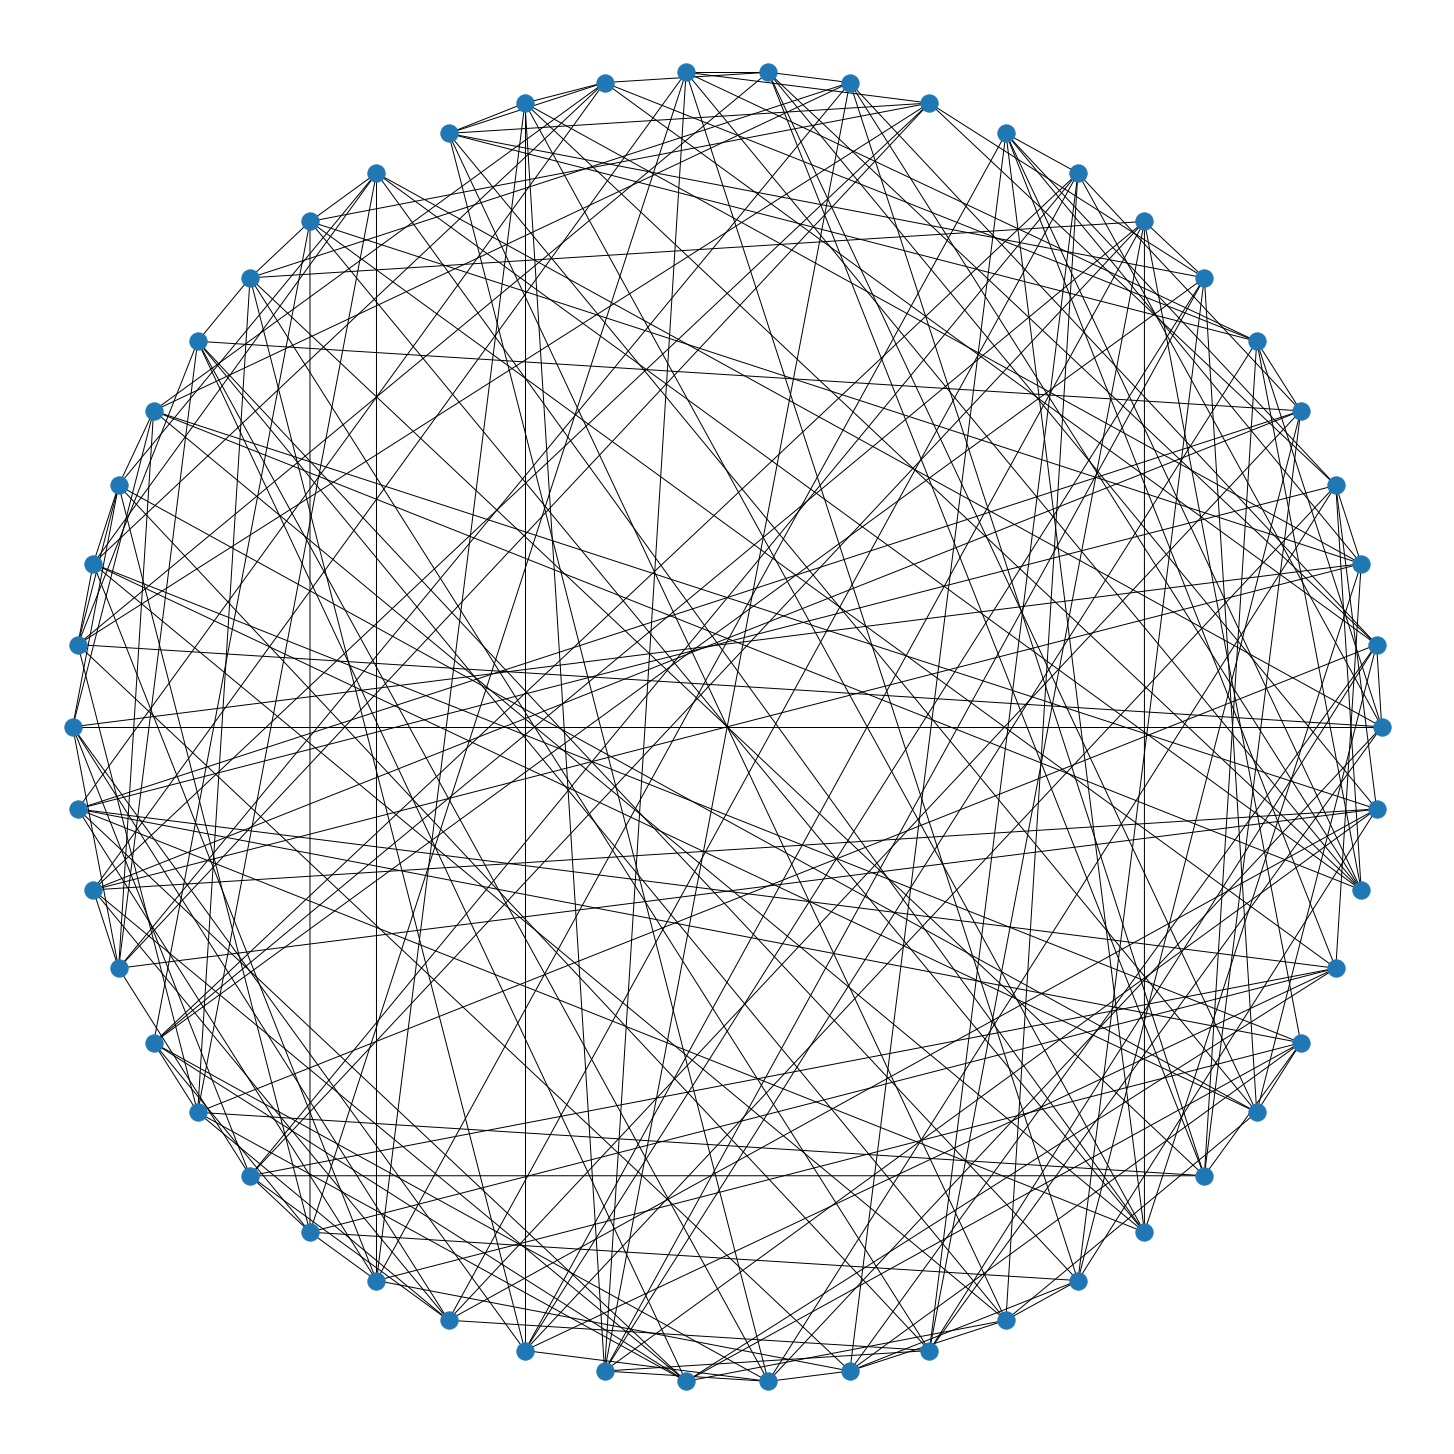

In [3]:
graph = nx.random_regular_graph(link, host)
plt.figure(1,figsize=(20,20)) 
nx.draw(graph, pos=nx.circular_layout(graph))
plt.show()

Write down the topology into file:

In [4]:
file_name = "rrg_%s_%s" % (link, host)
nx.write_adjlist(graph, file_name)
graph = nx.read_adjlist(file_name)

Caculate the ECMP paths:

In [5]:
def compute_ecmp_paths(graph, host):
    ecmp_paths = {}
    for a in range(host):
        ecmp_paths[(str(a), str(a))] = [[str(a)]]
        for b in range(a + 1, host):
            shortest_paths = nx.all_shortest_paths(graph, source=str(a), target=str(b))
            ecmp_paths[(str(a), str(b))] = [p for p in shortest_paths]
    return ecmp_paths


ecmp_paths = compute_ecmp_paths(graph, host)
ecmp_paths[('0','1')]

[['0', '25', '31', '1'],
 ['0', '16', '31', '1'],
 ['0', '41', '15', '1'],
 ['0', '47', '15', '1'],
 ['0', '35', '49', '1'],
 ['0', '26', '28', '1'],
 ['0', '16', '28', '1'],
 ['0', '47', '7', '1'],
 ['0', '6', '7', '1'],
 ['0', '47', '19', '1'],
 ['0', '47', '39', '1']]

Save ECMP path into file:

In [6]:
def save_obj(obj, name):
    with open('pickled_routes/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
save_obj(ecmp_paths, "ecmp_%s" % (file_name))

Caculate k shortest paths:

In [7]:
def compute_k_shortest_paths(graph, n, k=8):
    all_ksp = {}
    for a in range(n):
        all_ksp[(str(a), str(a))] = [[str(a)]]
        for b in range(a + 1, n):
            ksp = list(islice(nx.shortest_simple_paths(graph, source=str(a), target=str(b)), k))
            all_ksp[(str(a), str(b))] = ksp
    return all_ksp


all_ksp = compute_k_shortest_paths(graph, host)
save_obj(ecmp_paths, "ecmp_%s" % (file_name))
all_ksp[('0','1')]

[['0', '25', '31', '1'],
 ['0', '41', '15', '1'],
 ['0', '35', '49', '1'],
 ['0', '26', '28', '1'],
 ['0', '16', '31', '1'],
 ['0', '47', '15', '1'],
 ['0', '16', '28', '1'],
 ['0', '6', '7', '1']]

And caculate the non-overlapping paths:

In [8]:
def reset_weight(graph, n):
    for u, v, a in graph.edges(data=True):
        graph[u][v]["weight"] = 1
        graph[v][u]["weight"] = 1


def get_weight(graph, path):
    cnt = 0
    for hd in range(len(path) - 1):
        cnt += graph[str(path[hd])][str(path[hd + 1])]["weight"]
    return cnt


def compute_non_overlapping_paths(graph, n):
    paths = {}
    for a in range(n):
        paths[(str(a), str(a))] = [[str(a)]]
        for b in range(a + 1, n):
            reset_weight(graph, n)
            while True:
                shortest_path = nx.shortest_path(graph, source=str(a), target=str(b), weight="weight")
                if get_weight(graph, shortest_path) > 100000:
                    break
                if (str(a), str(b)) not in paths:
                    paths[(str(a), str(b))] = [shortest_path]
                else:
                    paths[(str(a), str(b))].append(shortest_path)

                for hd in range(len(shortest_path) - 1):
                    graph[str(shortest_path[hd])][str(shortest_path[hd + 1])]["weight"] += 100000
                    graph[str(shortest_path[hd + 1])][str(shortest_path[hd])]["weight"] += 100000

    return paths


non_overlapping = compute_non_overlapping_paths(graph, host)
save_obj(non_overlapping, "unique_%s" % (file_name))
non_overlapping[('0','1')]

[['0', '25', '31', '1'],
 ['0', '41', '15', '1'],
 ['0', '35', '49', '1'],
 ['0', '26', '28', '1'],
 ['0', '47', '7', '1'],
 ['0', '16', '45', '40', '1'],
 ['0', '46', '14', '19', '1'],
 ['0', '6', '26', '27', '39', '1']]

Built the graph:

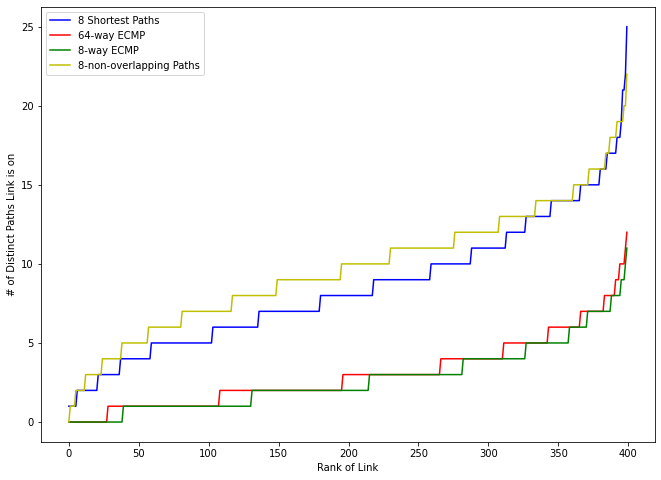

In [9]:
# Code adapted from:
# https://stackoverflow.com/questions/25200220/generate-a-random-derangement-of-a-list
def random_derangement(n):
    while True:
        v = list(range(n))
        for j in range(n - 1, -1, -1):
            p = random.randint(0, j)
            if v[p] == j:
                break
            else:
                v[j], v[p] = v[p], v[j]
        else:
            if v[0] != 0:
                return tuple(v)
            

def get_path_counts(distinct, ecmp_paths, all_ksp, traffic_matrix, all_links):
    counts = {}
    # initialize counts for all links
    for link in all_links:
        a, b = link
        counts[(str(a), str(b))] = {"8-ksp": 0, "8-ecmp": 0, "64-ecmp": 0, "distinct": 0}
        counts[(str(b), str(a))] = {"8-ksp": 0, "8-ecmp": 0, "64-ecmp": 0, "distinct": 0}
    for start_host in range(len(traffic_matrix)):
        dest_host = traffic_matrix[start_host]
        start_node = start_host // 3
        dest_node = dest_host // 3
        if start_node == dest_node:
            continue
        # swap them so that start_node < dest_node
        if start_node > dest_node:
            start_node, dest_node = dest_node, start_node
        paths = ecmp_paths[(str(start_node), str(dest_node))]
        if len(paths) > 64:
            paths = paths[:64]
        for i in range(len(paths)):
            path = paths[i]
            prev_node = None
            for node in path:
                if not prev_node:
                    prev_node = node
                    continue
                link = (str(prev_node), str(node))
                if i < 8:
                    counts[link]["8-ecmp"] += 1
                counts[link]["64-ecmp"] += 1
                prev_node = node

        ksp = all_ksp[(str(start_node), str(dest_node))]
        for path in ksp:
            prev_node = None
            for node in path:
                if not prev_node:
                    prev_node = node
                    continue
                link = (str(prev_node), str(node))
                counts[link]["8-ksp"] += 1
                prev_node = node

        ksp = distinct[(str(start_node), str(dest_node))]
        for path in ksp:
            prev_node = None
            for node in path:
                if not prev_node:
                    prev_node = node
                    continue
                link = (str(prev_node), str(node))
                counts[link]["distinct"] += 1
                prev_node = node

    return counts

def assemble_histogram(path_counts, file_name):
    ksp_distinct_paths_counts = []
    ecmp_8_distinct_paths_counts = []
    ecmp_64_distinct_paths_counts = []
    distinct_paths_counts = []

    for _, value in sorted(path_counts.items(), key=lambda kv: (kv[1]["8-ksp"], kv[0])):
        ksp_distinct_paths_counts.append(value["8-ksp"])
    for _, value in sorted(path_counts.items(), key=lambda kv: (kv[1]["8-ecmp"], kv[0])):
        ecmp_8_distinct_paths_counts.append(value["8-ecmp"])
    for _, value in sorted(path_counts.items(), key=lambda kv: (kv[1]["64-ecmp"], kv[0])):
        ecmp_64_distinct_paths_counts.append(value["64-ecmp"])
    for _, value in sorted(path_counts.items(), key=lambda kv: (kv[1]["distinct"], kv[0])):
        distinct_paths_counts.append(value["distinct"])

    #	print ksp_distinct_paths_counts
    #	print ecmp_8_distinct_paths_counts
    #	print ecmp_64_distinct_paths_counts
    x = range(len(ksp_distinct_paths_counts))
    fig = plt.figure(figsize=(11,8))
    ax1 = fig.add_subplot(111)

    ax1.plot(x, ksp_distinct_paths_counts, color='b', label="8 Shortest Paths")
    ax1.plot(x, ecmp_64_distinct_paths_counts, color='r', label="64-way ECMP")
    ax1.plot(x, ecmp_8_distinct_paths_counts, color='g', label="8-way ECMP")
    ax1.plot(x, distinct_paths_counts, color='y', label="8-non-overlapping Paths")
    plt.legend(loc="upper left");
    ax1.set_xlabel("Rank of Link")
    ax1.set_ylabel("# of Distinct Paths Link is on")
    plt.savefig("plots/%s_plot.png" % file_name)
    plt.show()


derangement = random_derangement(3 * host)
all_links = graph.edges()
path_counts = get_path_counts(non_overlapping,ecmp_paths, all_ksp, derangement, all_links)
assemble_histogram(path_counts=path_counts, file_name=file_name)

Convert path into controller format:

In [10]:
def load_obj(name ):
    with open('pickled_routes/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
    
def switch_to_dpid(switchIndex):
	return str(switchIndex) + "_1"

def save_routing_table(obj, name):
    with open('transformed_routes/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def transform_paths_dpid(paths_file_name, numSwitches, maxLen):
	all_paths = load_obj(paths_file_name)
	table = {}
	for key, value in all_paths.items():
		key_dpid = (switch_to_dpid(key[0]), switch_to_dpid(key[1]))
		table[key_dpid] = []
		reversed_key = (switch_to_dpid(key[1]), switch_to_dpid(key[0]))
		table[reversed_key] = []
		for path in value[:maxLen]:
			transformed_path = list(map(switch_to_dpid, path))
			table[key_dpid].append(transformed_path)
			table[reversed_key].append(transformed_path[::-1])
	return table

transformed_ksp_routes = transform_paths_dpid("ksp_%s" % (file_name), host, link)
save_routing_table(transformed_ksp_routes, "ksp_%s" % (file_name))

transformed_ecmp_routes = transform_paths_dpid("ecmp_%s" % (file_name), host, link)
save_routing_table(transformed_ecmp_routes, "ecmp_8_%s" % (file_name))

transformed_ecmp_routes = transform_paths_dpid("unique_%s" % (file_name), host, link)
save_routing_table(transformed_ecmp_routes, "unique_%s" % (file_name))